
# Detección de Retinopatía Diabética


In [1]:
# Importación de Librerías
from google.colab import drive, files
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import seaborn as sns
from itertools import chain
import shutil
from sklearn.utils import class_weight, shuffle
import cv2

In [4]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0


In [5]:
!pip install tensorflow==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    F

In [2]:
import tensorflow as tf

print(tf.__version__)

2.13.0


In [3]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5006 sha256=fa15c2bf77ffee9fe78a4acc123be113f226313ed661ab1b1690ff54bec5ef1f
  Stored in directory: /root/.cache/pip/wheels/68/2f/bc/76f1192d474666d41ae6f09813fccbd00fe3f07e8261c4cff5
Successfully built timeout-decorator


In [4]:
!pip install tensorboard==2.13.0

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 22 11:59:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [6]:
#GPU test de Google Colab
print("GPU disponible: ", tf.config.list_physical_devices('GPU'))

GPU disponible:  []


In [5]:
#Montamos Drive y marcamos las rutas a las carpetas de imágenes.
drive.mount ('/content/drive', force_remount=True)
ruta_imagenes = Path('/content/drive/MyDrive/Colab Notebooks/Train zip 1')

Mounted at /content/drive


In [10]:
ruta_imagenes= '/content/drive/MyDrive/Colab Notebooks/Train zip 1'

In [7]:
#Cargo el dataframe con las etiquetas
ruta_df = '/content/drive/MyDrive/Colab Notebooks/trainLabels.csv'

#Generamos DF con los Train Labels
df = pd.read_csv(ruta_df)
df

image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]

In [11]:
files = Path(ruta_imagenes).glob("*.jpeg")

In [12]:
imagenes = list(files)
print(f"Estamos trabajando con un total de {len(imagenes)} imágenes")
imagenes[:5]

Estamos trabajando con un total de 25047 imágenes


[PosixPath('/content/drive/MyDrive/Colab Notebooks/Train zip 1/37727_right.jpeg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Train zip 1/37730_left.jpeg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Train zip 1/37730_right.jpeg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Train zip 1/37726_left.jpeg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Train zip 1/37736_left.jpeg')]

**Trabajo sobre el data frame con los Labels**:

* El DF tiene más registros que las imágenes que usaremos.
* Hay dos registros por cada peciente, uno por ojo.
* Debemos agrrgar la Ruta del Archivo para pasar al Image Generator
* Debemos codificar con one-hot la categoría para pasarlo al Image Generator.
* Crearemos columnas que nos ayuden a filtrar.







In [13]:
#Filtramos solo las imágenes que le pasaremos a la Red.
nombre_archivos = [imagen.name[:-5] for imagen in imagenes]
nombre_archivos[:5]

['37727_right', '37730_left', '37730_right', '37726_left', '37736_left']

In [14]:
#Filtro
df_filtrado = df[df['image'].isin(nombre_archivos)]
df_filtrado

image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
30678   38781_left      0
30679  38781_right      0
30680   38789_left      2
30681  38789_right      1
30682   38790_left      0

[25027 rows x 2 columns]

Trabajaremos con la categoría Binaria:
* 0 = No detecta Rinopatía (negativo)
* 1 = Rinopatía detectada (positivo)

In [15]:
df_filtrado['level'] = df_filtrado['level'].apply(lambda x: 1 if x > 0 else x)
df_filtrado.head()

<ipython-input-15-17a089777327>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['level'] = df_filtrado['level'].apply(lambda x: 1 if x > 0 else x)


image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [16]:
#Agregamos la Columna 'PatientID':
df_filtrado.loc[:,'PatientId'] = df_filtrado['image'].map(lambda x: x.split('_')[0])

# Agregamos la columna que contiene la Ruta a la Imágen:
df_filtrado.loc[:,"Ruta_Imagen"] = df_filtrado['image'].map(lambda x: os.path.join(ruta_imagenes,
                                                         '{}.jpeg'.format(x)))

# Usamos .exists de Path, para garantizar que la ruta al archivo dirige a la imágen en cuestión:
df_filtrado.loc[:,'Contiene Archivo'] = df_filtrado['Ruta_Imagen'].map(os.path.exists)

#Agragamos la columna 'Ojo', 1 representa el Ojo Izquierdo y 0 el Ojo Derecho:
df_filtrado.loc[:, 'Ojo'] = df_filtrado['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

#Agrgamos una columna con las representaciones categóricas de los valores de 'level'
df_filtrado.loc[:,'level_cat'] = df_filtrado['level'].map(lambda x: to_categorical(x, 1+df_filtrado['level'].max()))



<ipython-input-16-f8439d0d459b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:,'PatientId'] = df_filtrado['image'].map(lambda x: x.split('_')[0])
<ipython-input-16-f8439d0d459b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:,"Ruta_Imagen"] = df_filtrado['image'].map(lambda x: os.path.join(ruta_imagenes,
<ipython-input-16-f8439d0d459b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [17]:
print(df_filtrado['Contiene Archivo'].sum(), 'images found of', df_filtrado.shape[0], 'total')

25027 images found of 25027 total


In [18]:
pd.set_option('display.max_colwidth', None)
df_filtrado.head()


image  level PatientId  \
0   10_left      0        10   
1  10_right      0        10   
2   13_left      0        13   
3  13_right      0        13   
4   15_left      1        15   

                                                        Ruta_Imagen  \
0   /content/drive/MyDrive/Colab Notebooks/Train zip 1/10_left.jpeg   
1  /content/drive/MyDrive/Colab Notebooks/Train zip 1/10_right.jpeg   
2   /content/drive/MyDrive/Colab Notebooks/Train zip 1/13_left.jpeg   
3  /content/drive/MyDrive/Colab Notebooks/Train zip 1/13_right.jpeg   
4   /content/drive/MyDrive/Colab Notebooks/Train zip 1/15_left.jpeg   

   Contiene Archivo  Ojo   level_cat  
0              True    1  [1.0, 0.0]  
1              True    0  [1.0, 0.0]  
2              True    1  [1.0, 0.0]  
3              True    0  [1.0, 0.0]  
4              True    1  [0.0, 1.0]

`Análisis Descriptivo del DataFrame:`

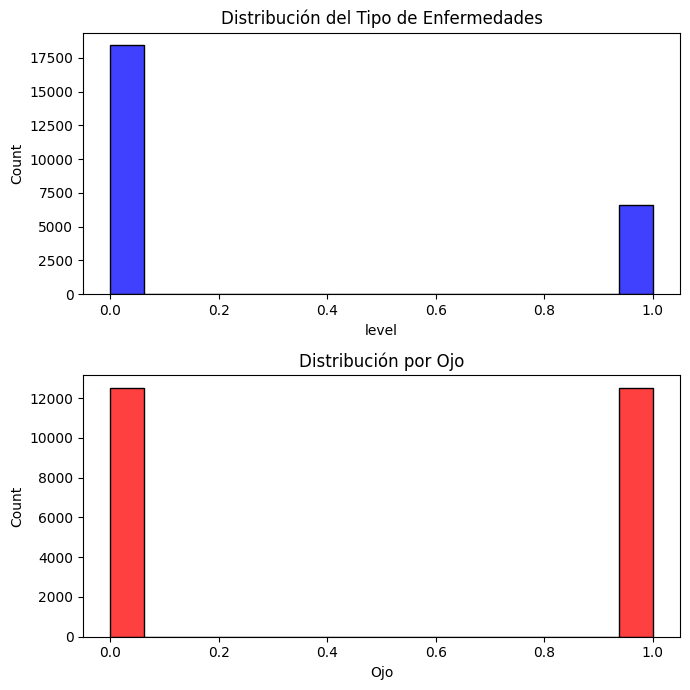

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))
ax[0].set_title('Distribución del Tipo de Enfermedades')
sns.histplot(x=df_filtrado.level, ax=ax[0], color='blue', edgecolor='black')
ax[1].set_title('Distribución por Ojo')
sns.histplot(x=df_filtrado.Ojo, ax=ax[1], color='r')

plt.tight_layout()
plt.show()


Tenemos un desbalance de clases




In [19]:
df_filtrado.level.value_counts()

level
0    18437
1     6590
Name: count, dtype: int64

In [24]:
print(f"Valores nulos en el DF: \n{df_filtrado.isna().sum()}")

Valores nulos en el DF: 
image               0
level               0
PatientId           0
Ruta_Imagen         0
Contiene Archivo    0
Ojo                 0
level_cat           0
dtype: int64


In [25]:
print(f"Imágenes Repetidas: {df_filtrado.iloc[:,:-1].duplicated().sum()}")



Imágenes Repetidas: 0


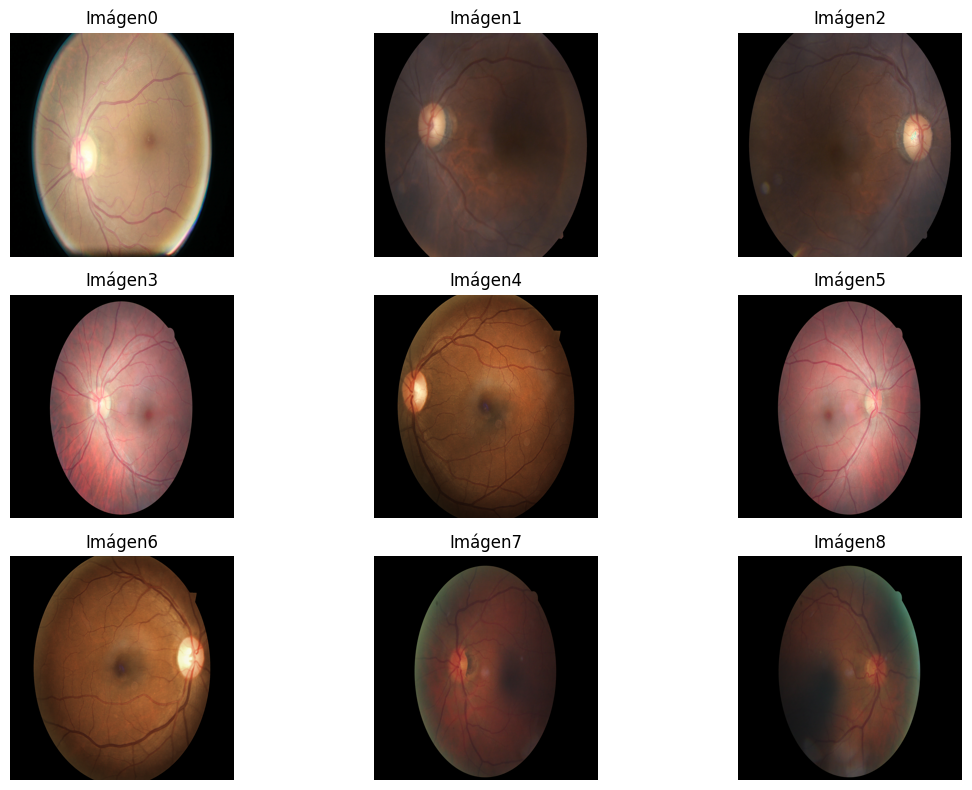

In [26]:
eyes_images = []
for i in range(9):
    imag_path = imagenes[i]
    #Utilizamos la Librería PIL (pillow) para abrir y reajstar las imágenes
    img = Image.open(imag_path)
    img = img.resize((224, 224))
    #Normalización de las imágenes [0-1]
    img_array = np.array(img) / 255.0
    eyes_images.append(img_array)


plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(eyes_images[i])
    plt.title(f'Imágen{i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

- El código anterior se ejecuto del 15 al 16 de mayo, tardó 8h., y en principio solo encontró una imagen dañada, la eliminada en la calda posterior.

In [20]:
enlaces_a_eliminar = ['/content/drive/MyDrive/Colab Notebooks/Train zip 1/38790_right.jpeg',
                      '/content/drive/MyDrive/Colab Notebooks/Train zip 1/29126_right.jpeg',
                      '/content/drive/MyDrive/Colab Notebooks/Train zip 1/28019_right.jpeg']

# Filtrar el DataFrame para eliminar las filas correspondientes a los enlaces
df_filtrado = df_filtrado[~df_filtrado['Ruta_Imagen'].isin(enlaces_a_eliminar)]

df_filtrado.head()

image  level PatientId  \
0   10_left      0        10   
1  10_right      0        10   
2   13_left      0        13   
3  13_right      0        13   
4   15_left      1        15   

                                                        Ruta_Imagen  \
0   /content/drive/MyDrive/Colab Notebooks/Train zip 1/10_left.jpeg   
1  /content/drive/MyDrive/Colab Notebooks/Train zip 1/10_right.jpeg   
2   /content/drive/MyDrive/Colab Notebooks/Train zip 1/13_left.jpeg   
3  /content/drive/MyDrive/Colab Notebooks/Train zip 1/13_right.jpeg   
4   /content/drive/MyDrive/Colab Notebooks/Train zip 1/15_left.jpeg   

   Contiene Archivo  Ojo   level_cat  
0              True    1  [1.0, 0.0]  
1              True    0  [1.0, 0.0]  
2              True    1  [1.0, 0.0]  
3              True    0  [1.0, 0.0]  
4              True    1  [0.0, 1.0]

MUESTRA ALEATORIA PARA EXAMINAR LA CALIDAD DE LAS IMÁGENES

- Selecciono 9 imagenes aleatoriamente, se muestran sin procesar, solo se redimensionan al numero más bajo de pixeles de las imagenes del conjunto, para posteriormente calcular la nitidez de éstas.

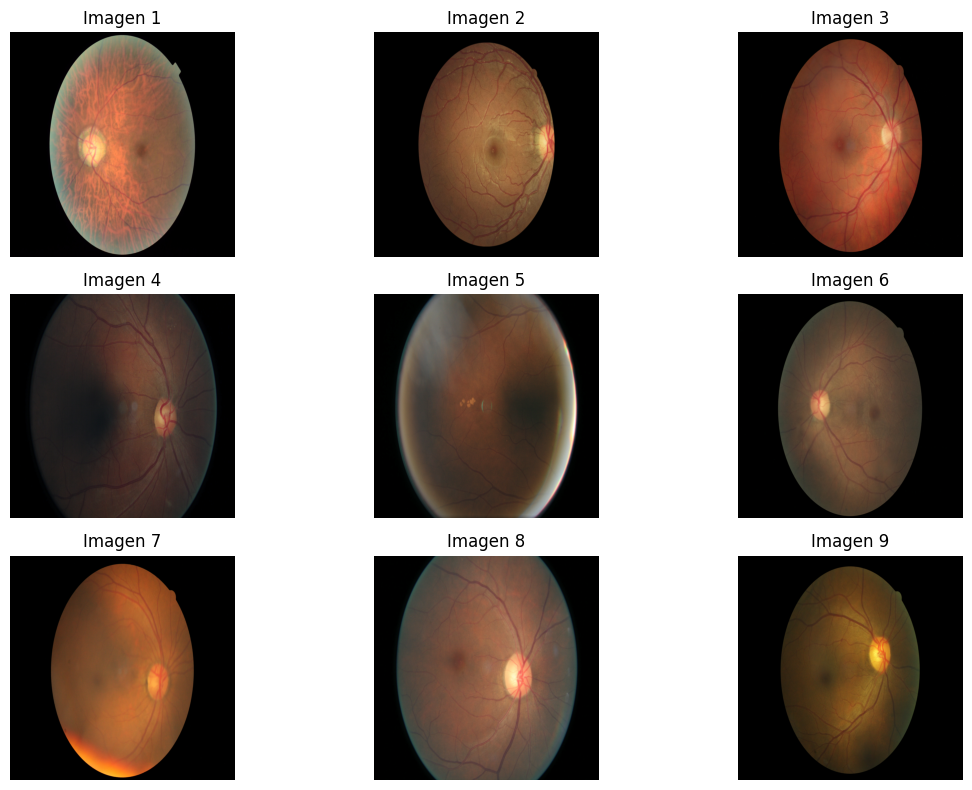

In [ ]:
import random

# Obtener una muestra aleatoria de nombres de imágenes
muestra_aleatoria = random.sample(list(df_filtrado['Ruta_Imagen']), k=9)

# Crear una lista para almacenar las imágenes de la muestra aleatoria
muestra_aleatoria_imagenes = []

# Iterar sobre los nombres de las imágenes en la muestra aleatoria
for nombre_imagen in muestra_aleatoria:
    # Obtener la ruta completa de la imagen
    imagen_path = os.path.join(ruta_imagenes, nombre_imagen)

    # Utilizar PIL para abrir y ajustar el tamaño de la imagen
    img = Image.open(imagen_path)
    img = img.resize((1000, 1000))

    # Normalizar la imagen
    img_array = np.array(img) #/ 255.0

    # Agregar la imagen normalizada a la lista
    muestra_aleatoria_imagenes.append(img_array)

# Visualizar las imágenes de la muestra aleatoria
plt.figure(figsize=(12, 8))

for i in range(len(muestra_aleatoria_imagenes)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(muestra_aleatoria_imagenes[i])
    plt.title(f'Imagen {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import exposure

In [ ]:
# Obtener el tamaño de cada imagen en la muestra aleatoria
tamaños_imagenes = [imagen.shape[:2] for imagen in muestra_aleatoria_imagenes]

# Encontrar el tamaño más pequeño de las imágenes en la muestra
tamaño_más_pequeño = min(tamaños_imagenes)

# Imprimir el tamaño más pequeño de las imágenes en la muestra
print("Tamaño más pequeño de las imágenes en la muestra:", tamaño_más_pequeño)

Tamaño más pequeño de las imágenes en la muestra: (1000, 1000)


Índice de Nitidez (SSIM):
El índice de nitidez (Structural Similarity Index) compara la similitud estructural entre dos imágenes. Un valor más cercano a 1 indica una mayor similitud y, por lo tanto, una mayor nitidez entre las imágenes

In [ ]:
# Calcular el índice de nitidez para cada par de imágenes de prueba
# Para calcular la nitidez, las imagenes deben tener el mismo numero en el par de pixeles

# Definir el tamaño de la ventana
win_size = 999  # Tamaño de la ventana, que sea un número impar menor o igual al tamaño más pequeño de las imágenes
channel_axis = -1  # Marca que los canales de color están en el último eje (el eje -1)

for i in range(len(muestra_aleatoria_imagenes)):
    for j in range(i+1, len(muestra_aleatoria_imagenes)):
        # Calcular el índice de nitidez entre las imágenes i y j
        indice_nitidez = ssim(muestra_aleatoria_imagenes[i], muestra_aleatoria_imagenes[j], win_size=win_size, channel_axis=channel_axis)
        print(f"Índice de nitidez entre imagen {i} y {j}: {indice_nitidez}")

Índice de nitidez entre imagen 0 y 1: 0.6225956099843845
Índice de nitidez entre imagen 0 y 2: 0.6699801079640689
Índice de nitidez entre imagen 0 y 3: 0.3414325617451181
Índice de nitidez entre imagen 0 y 4: 0.23333337203900525
Índice de nitidez entre imagen 0 y 5: 0.7246659102167516
Índice de nitidez entre imagen 0 y 6: 0.7076183117763533
Índice de nitidez entre imagen 0 y 7: 0.6371710595983595
Índice de nitidez entre imagen 0 y 8: 0.4392875825699247
Índice de nitidez entre imagen 1 y 2: 0.9069362312436272
Índice de nitidez entre imagen 1 y 3: 0.5323501710769136
Índice de nitidez entre imagen 1 y 4: 0.15416742853729096
Índice de nitidez entre imagen 1 y 5: 0.8646140586748938
Índice de nitidez entre imagen 1 y 6: 0.8459953702735592
Índice de nitidez entre imagen 1 y 7: 0.5989605253978124
Índice de nitidez entre imagen 1 y 8: 0.7963238520506017
Índice de nitidez entre imagen 2 y 3: 0.5553835265724
Índice de nitidez entre imagen 2 y 4: 0.15671659083600067
Índice de nitidez entre imagen 

Las combinaciones de imágenes con índices de nitidez más altos indican una mayor similitud estructural entre esas imágenes. Se puede interpretar como que las imágenes son visualmente similares en términos de detalles y estructura.
Por otro lado, las combinaciones con índices de nitidez más bajos pueden indicar diferencias significativas en la estructura visual entre las imágenes.
Esto puede ser útil para identificar imágenes que pertenecen a la misma clase o categoría en el conjunto de datos.

- Para un modelo de clasificación, se podrían eliminar o dar más o menos peso a las imágenes que tienen una baja similitud estructural con otras en la misma clase.

- Si hay imágenes con índices de nitidez consistentemente bajos, esto podría indicar problemas de calidad en esas imágenes, como desenfoque o artefactos. En este caso, se podrían aplicar técnicas de preprocesamiento de imágenes para mejorar la calidad de esas imágenes o eliminarlas si no son útiles.

El contraste indica la diferencia de luminancia entre las regiones claras y oscuras de una imagen. Un contraste bajo puede indicar que la imagen tiene una distribución de luminancia más uniforme y menos diferenciada entre las áreas claras y oscuras.

In [ ]:
# Calcular el contraste para una imagen

contraste = exposure.is_low_contrast(muestra_aleatoria_imagenes)
print("¿Contraste bajo?", contraste)

¿Contraste bajo? False


 - El resultado indica que el contraste no es bajo en las imágenes. Esto sugiere que tienen una distribución de luminancia suficientemente diferenciada entre las áreas claras y oscuras, lo que puede ser beneficioso para la visualización y el análisis

Entropía: Mide la cantidad de información en una imagen. Una imagen con una alta entropía tiene una mayor variabilidad y puede considerarse más compleja.

In [ ]:
from skimage.measure import shannon_entropy
from skimage.feature import hog
from skimage import exposure

In [ ]:
entropia_features = []

# Iterar sobre cada imagen en la lista
for imagen in muestra_aleatoria_imagenes:
  entropia = shannon_entropy(imagen)
  entropia_features.append(entropia)

# Imprimir las características calculadas
for i, (entropia_feature) in enumerate(zip(entropia_features)):
    print(f"Imagen {i+1}:")
    print("   Entropía de Shannon:", entropia_feature)

Imagen 1:
   Entropía de Shannon: (4.894463273708715,)
Imagen 2:
   Entropía de Shannon: (4.0887954433674185,)
Imagen 3:
   Entropía de Shannon: (4.761958213684002,)
Imagen 4:
   Entropía de Shannon: (5.7067355326993585,)
Imagen 5:
   Entropía de Shannon: (6.21505106625917,)
Imagen 6:
   Entropía de Shannon: (4.1711661479980995,)
Imagen 7:
   Entropía de Shannon: (4.546575578099665,)
Imagen 8:
   Entropía de Shannon: (5.915555051575276,)
Imagen 9:
   Entropía de Shannon: (4.073634960013008,)


- Mayor entropía: Una entropía más alta indica una mayor cantidad de variabilidad o desorden en la distribución de píxeles de la imagen. Esto puede sugerir que la imagen tiene características más complejas o una distribución de valores de píxeles menos predecible.

- Menor entropía: Una entropía más baja indica una distribución de píxeles más ordenada o menos variabilidad en la imagen. Esto puede sugerir que la imagen tiene características más uniformes o una distribución de valores de píxeles más predecible.

- Comparación entre imágenes: comparar los valores de entropía entre diferentes imágenes de la muestra para identificar las que tienen características visuales más complejas o más simples en términos de la distribución de píxeles.

Histograma de gradiente: Mide la distribución de los gradientes en una imagen. Puede ser útil para evaluar el nivel de detalles y bordes presentes en una imagen

In [ ]:
# Calcular el histograma de gradiente (HOG) de la imagen

hog_features = []
visualizaciones_hog = []
channel_axis = -1

# Iterar sobre cada imagen en la lista
for imagen in muestra_aleatoria_imagenes:
    # Calcular el Histograma de Gradientes Orientados (HOG)
    histograma_gradiente, hog_visualization = hog(imagen, visualize=True, channel_axis=channel_axis)
    hog_features.append(histograma_gradiente)
    visualizaciones_hog.append(hog_visualization)

# Imprimir las características calculadas
for i, (hog_feature) in enumerate(zip(hog_features)):
    print(f"Imagen {i+1}:")
    print("   Histograma de Gradientes Orientados (HOG):", hog_feature)

Imagen 1:
   Histograma de Gradientes Orientados (HOG): (array([0., 0., 0., ..., 0., 0., 0.]),)
Imagen 2:
   Histograma de Gradientes Orientados (HOG): (array([0., 0., 0., ..., 0., 0., 0.]),)
Imagen 3:
   Histograma de Gradientes Orientados (HOG): (array([0.37571202, 0.        , 0.09488161, ..., 0.        , 0.        ,
       0.        ]),)
Imagen 4:
   Histograma de Gradientes Orientados (HOG): (array([0.2790036 , 0.        , 0.04079883, ..., 0.        , 0.        ,
       0.        ]),)
Imagen 5:
   Histograma de Gradientes Orientados (HOG): (array([0., 0., 0., ..., 0., 0., 0.]),)
Imagen 6:
   Histograma de Gradientes Orientados (HOG): (array([0., 0., 0., ..., 0., 0., 0.]),)
Imagen 7:
   Histograma de Gradientes Orientados (HOG): (array([0., 0., 0., ..., 0., 0., 0.]),)
Imagen 8:
   Histograma de Gradientes Orientados (HOG): (array([0.        , 0.        , 0.        , ..., 0.26420656, 0.25064834,
       0.        ]),)
Imagen 9:
   Histograma de Gradientes Orientados (HOG): (array([0.,

Cada valor en el histograma codifica tanto la magnitud como la orientación del gradiente. Los valores más altos indican gradientes más pronunciados en esa dirección, mientras que los valores más bajos pueden representar regiones con gradientes suaves o sin cambios significativos.

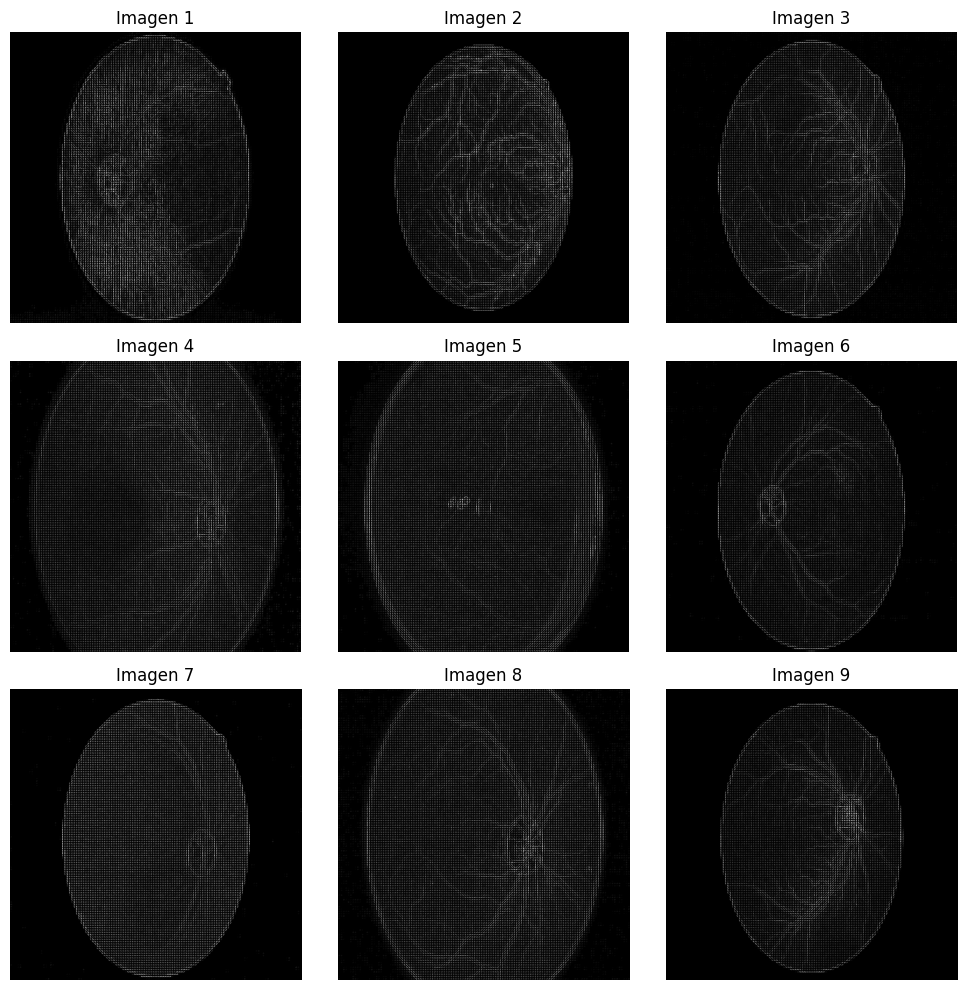

In [ ]:
# Mostrar las visualizaciones de HOG en una cuadrícula
num_filas = 3
num_columnas = 3

plt.figure(figsize=(10, 10))

for i in range(len(visualizaciones_hog)):
    plt.subplot(num_filas, num_columnas, i + 1)
    # Mejorar el contraste de la visualización de HOG
    plt.imshow(exposure.rescale_intensity(visualizaciones_hog[i], in_range=(0, 5)), cmap='gray')
    plt.title(f'Imagen {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

- PREPROCESAMIENTO

CPU times: user 21.8 s, sys: 177 ms, total: 22 s
Wall time: 16.7 s


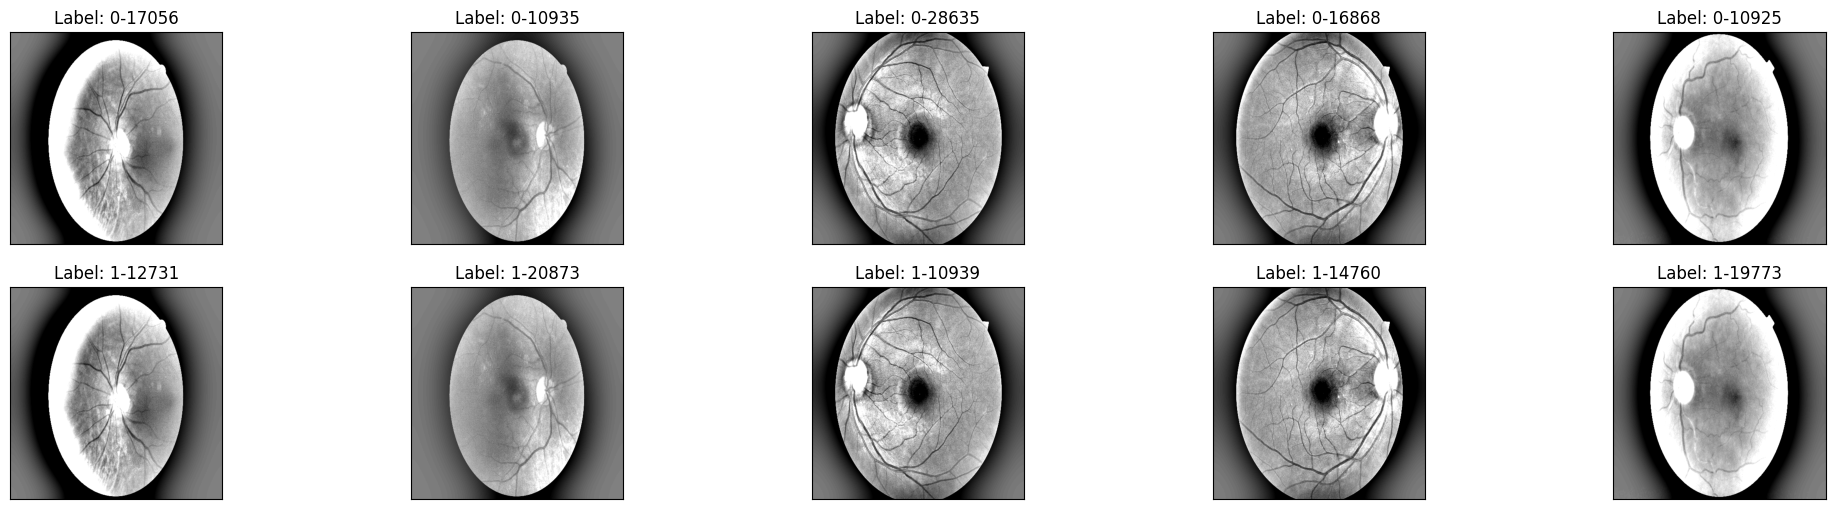

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(df_filtrado['level'].unique()):

    for i, (idx, row) in enumerate(df_filtrado.loc[df_filtrado['level'] == class_id].sample(5, random_state=42).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        imag_path = df_filtrado["Ruta_Imagen"].iloc[i]
        image = cv2.imread(imag_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d' % (class_id, idx ))

Este bloque de código también visualiza un conjunto de muestras de imágenes de diferentes clases, pero utiliza una escala de grises en lugar de una representación en color. Aquí hay un resumen del proceso:

- Se define el tamaño de la figura de Matplotlib (figsize) para mostrar las imágenes.
- Se itera sobre cada clase en el conjunto de datos de entrenamiento (train_y.unique()).
- Para cada clase, se seleccionan 5 muestras aleatorias y se itera sobre ellas.
- Para cada muestra seleccionada, se carga la imagen desde la ruta especificada utilizando OpenCV (cv2.imread).
- Se convierte la imagen a escala de grises utilizando cv2.cvtColor.
- Se redimensiona la imagen a un tamaño específico (512x512 píxeles) utilizando cv2.resize.
- Se aplica un efecto de desenfoque gaussiano y se ajusta el brillo de la imagen utilizando cv2.addWeighted.
- Se añade cada imagen a la figura de Matplotlib en una disposición de filas y columnas, y se establece el título de cada subfigura con el formato "clase-índice".







In [21]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

Esta función crop_image_from_gray recorta una imagen basada en su intensidad de gris. Si la imagen es en escala de grises (2D), la función busca píxeles con valores de intensidad superiores a un umbral (tol) y recorta la imagen para eliminar las áreas completamente oscuras.

Si la imagen es a color (3D), primero se convierte a escala de grises y luego se aplica el mismo proceso. Sin embargo, si la imagen resultante es demasiado oscura (es decir, no se detectan píxeles con intensidad suficiente), se devuelve la imagen original sin recortar.

Aquí hay un resumen de cómo funciona la función:

Si la imagen es en escala de grises (2D):
- Crea una máscara booleana de píxeles con intensidad superior al umbral especificado (tol).
- Utiliza esta máscara para recortar la imagen y eliminar las áreas oscuras.
Si la imagen es a color (3D):
- Convierte la imagen a escala de grises.
- Realiza el mismo proceso de recorte, pero para cada canal de color por separado.
- Si la imagen resultante es demasiado oscura y no se detectan píxeles con intensidad suficiente, se devuelve la imagen original sin recortar.
Esto puede ser útil para eliminar áreas oscuras o insignificantes en una imagen antes de realizar ciertas operaciones de procesamiento de imágenes.

In [22]:
def load_ben_color(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    return image

Esta función load_ben_color carga una imagen desde la ruta especificada y luego aplica una serie de transformaciones para mejorar su calidad y prepararla para su procesamiento adicional. Aquí está el proceso paso a paso:

- Lee la imagen desde la ruta especificada utilizando OpenCV (cv2.imread). OpenCV carga la imagen en el formato BGR (azul, verde, rojo).
- Convierte la imagen de BGR a RGB, ya que OpenCV carga la imagen en formato BGR, pero muchos otros procesos esperan imágenes en formato RGB.
- Recorta la imagen utilizando la función crop_image_from_gray para eliminar las áreas completamente oscuras o insignificantes.
- Cambia el tamaño de la imagen a una resolución de 512x512 píxeles.
- Aplica un desenfoque gaussiano a la imagen para suavizarla. El parámetro sigmaX controla la intensidad del desenfoque.
- Ajusta el brillo y el contraste de la imagen utilizando la función cv2.addWeighted para mejorar la calidad visual.

Finalmente, la función devuelve la imagen transformada y mejorada. Este tipo de preprocesamiento es común en aplicaciones de visión por computadora para mejorar la calidad de las imágenes antes de la segmentación, detección de objetos u otras tareas de análisis.

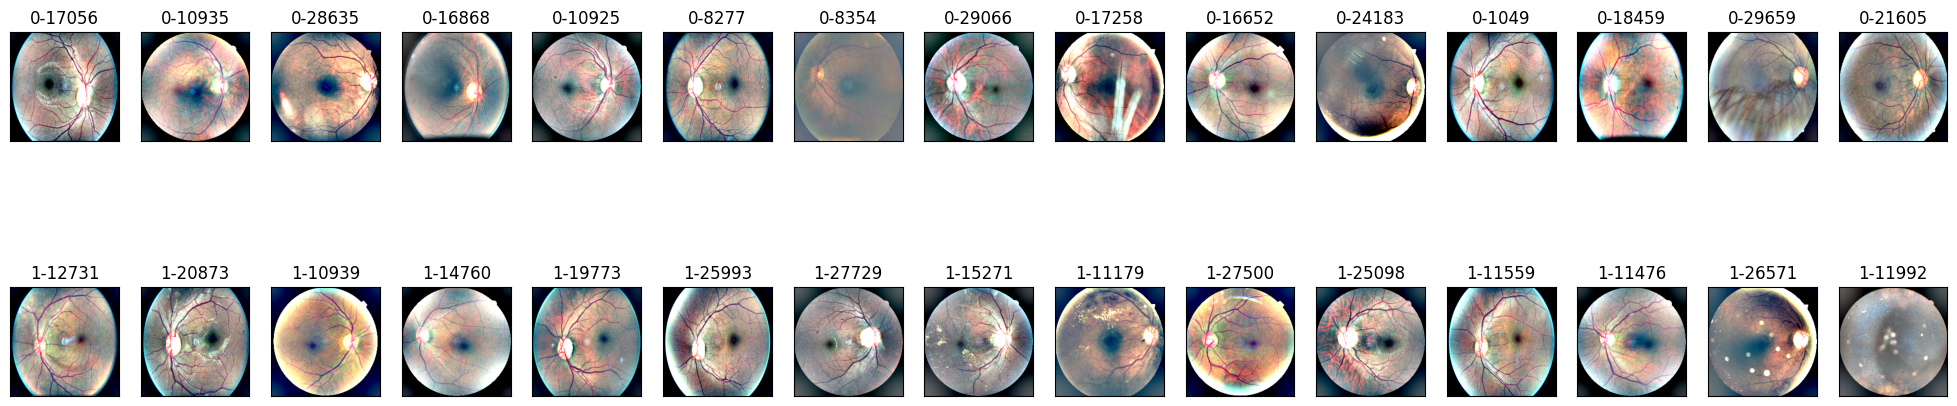

In [23]:
NUM_SAMP = 15
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(df_filtrado['level'].unique()):
    class_df = df_filtrado.loc[df_filtrado['level'] == class_id]
    if class_df.shape[0] < NUM_SAMP:
        raise ValueError(f"No hay suficientes muestras para la clase {class_id}. Disponible: {class_df.shape[0]}, Requerido: {NUM_SAMP}")

    for i, (idx, row) in enumerate(class_df.sample(NUM_SAMP, random_state=42).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path = row['Ruta_Imagen']
        image = load_ben_color(cv2.imread(path), sigmaX=30)  # Asegúrate de leer la imagen antes de pasarla
        plt.imshow(image)
        ax.set_title('%d-%d' % (class_id, idx))

plt.show()

In [24]:
def preprocess_rgb_images(image, sigmaX=10):
    try:
        image = load_ben_color(image, sigmaX=30)
        return image
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

Este código utiliza la biblioteca Matplotlib para visualizar un conjunto de muestras de imágenes de diferentes clases. Aquí hay un resumen del proceso:

- Se define el número de muestras por clase (NUM_SAMP) que se desea mostrar en la visualización.
- Se crea una figura de Matplotlib (fig) con un tamaño específico para mostrar las imágenes.
- Se itera sobre cada clase en el conjunto de datos de entrenamiento (train_y.unique()) y se selecciona un número de muestras aleatorias (NUM_SAMP) de esa clase.
- Para cada muestra seleccionada, se carga la imagen desde la ruta especificada y se aplica el preprocesamiento utilizando la función load_ben_color.
- Se añade cada imagen a la figura de Matplotlib en una disposición de filas y columnas, y se establece el título de cada subfigura con el formato "clase-índice".

El uso de %%time al principio del bloque de código indica que se desea medir el tiempo de ejecución de la celda. Esto es útil para obtener información sobre la eficiencia del código y el rendimiento de la visualización.







In [25]:
# stratify=df_filtrado['level'] en train_test_split garantiza que la división mantenga la proporción de las clases en ambos conjuntos
train_df, aux_df = train_test_split(df_filtrado, test_size=0.3, random_state=42, stratify=df_filtrado['level'])

# Verificar que los DataFrames no estén vacíos
assert not train_df.empty, "El DataFrame de entrenamiento está vacío."
assert not aux_df.empty, "El DataFrame de prueba está vacío."

In [26]:
test_df, val_df = train_test_split(aux_df, test_size=0.5, random_state=42, stratify=aux_df['level'])

In [27]:
train_df['level'] = train_df['level'].astype(str)
train_df.head()

image level PatientId  \
18223  22951_right     1     22951   
29601  37460_right     0     37460   
16522   20739_left     0     20739   
9883   12460_right     0     12460   
10442   13144_left     0     13144   

                                                               Ruta_Imagen  \
18223  /content/drive/MyDrive/Colab Notebooks/Train zip 1/22951_right.jpeg   
29601  /content/drive/MyDrive/Colab Notebooks/Train zip 1/37460_right.jpeg   
16522   /content/drive/MyDrive/Colab Notebooks/Train zip 1/20739_left.jpeg   
9883   /content/drive/MyDrive/Colab Notebooks/Train zip 1/12460_right.jpeg   
10442   /content/drive/MyDrive/Colab Notebooks/Train zip 1/13144_left.jpeg   

       Contiene Archivo  Ojo   level_cat  
18223              True    0  [0.0, 1.0]  
29601              True    0  [1.0, 0.0]  
16522              True    1  [1.0, 0.0]  
9883               True    0  [1.0, 0.0]  
10442              True    1  [1.0, 0.0]

In [28]:
train_df.to_csv('./drive/MyDrive/FINAL-train_df.csv', index=False)

In [29]:
val_df['level'] = val_df['level'].astype(str)
val_df.head()

image level PatientId  \
13498   16946_left     0     16946   
10868   13670_left     0     13670   
27848   35279_left     0     35279   
15611  19531_right     0     19531   
21479  27049_right     0     27049   

                                                               Ruta_Imagen  \
13498   /content/drive/MyDrive/Colab Notebooks/Train zip 1/16946_left.jpeg   
10868   /content/drive/MyDrive/Colab Notebooks/Train zip 1/13670_left.jpeg   
27848   /content/drive/MyDrive/Colab Notebooks/Train zip 1/35279_left.jpeg   
15611  /content/drive/MyDrive/Colab Notebooks/Train zip 1/19531_right.jpeg   
21479  /content/drive/MyDrive/Colab Notebooks/Train zip 1/27049_right.jpeg   

       Contiene Archivo  Ojo   level_cat  
13498              True    1  [1.0, 0.0]  
10868              True    1  [1.0, 0.0]  
27848              True    1  [1.0, 0.0]  
15611              True    0  [1.0, 0.0]  
21479              True    0  [1.0, 0.0]

In [30]:
val_df.to_csv('./drive/MyDrive/FINAL-val_df.csv', index=False)

In [31]:
test_df['level'] = test_df['level'].astype(str)
test_df.head()

image level PatientId  \
29045  36755_right     0     36755   
20734   26131_left     0     26131   
22303  28122_right     1     28122   
14165  17788_right     1     17788   
17173  21560_right     0     21560   

                                                               Ruta_Imagen  \
29045  /content/drive/MyDrive/Colab Notebooks/Train zip 1/36755_right.jpeg   
20734   /content/drive/MyDrive/Colab Notebooks/Train zip 1/26131_left.jpeg   
22303  /content/drive/MyDrive/Colab Notebooks/Train zip 1/28122_right.jpeg   
14165  /content/drive/MyDrive/Colab Notebooks/Train zip 1/17788_right.jpeg   
17173  /content/drive/MyDrive/Colab Notebooks/Train zip 1/21560_right.jpeg   

       Contiene Archivo  Ojo   level_cat  
29045              True    0  [1.0, 0.0]  
20734              True    1  [1.0, 0.0]  
22303              True    0  [0.0, 1.0]  
14165              True    0  [0.0, 1.0]  
17173              True    0  [1.0, 0.0]

In [32]:
test_df.to_csv('./drive/MyDrive/FINAL-test_df.csv', index=False)

In [34]:
# Generador de datos con manejo de excepciones
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_rgb_images # Notar que aquí solo se pasa preprocess_image
)

# Crear generadores de imágenes para entrenamiento, validación y prueba
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Ruta_Imagen',
    y_col='level',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

val_data = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Ruta_Imagen',
    y_col='level',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Ruta_Imagen",
    y_col="level",
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 17518 validated image filenames belonging to 2 classes.
Found 3755 validated image filenames belonging to 2 classes.
Found 3754 validated image filenames belonging to 2 classes.


In [ ]:
# Accede a un lote de datos de entrenamiento
batch_x, batch_y = next(train_data)

# Imprime la forma del lote de datos de entrenamiento
print("Forma del lote de train_generator:", batch_x.shape)
print("Tipo de datos de train_generator:", batch_x.dtype)
print("Forma del lote de train_generator:", batch_y.shape)

Forma del lote de train_generator: (20, 224, 224, 3)
Tipo de datos de train_generator: float32
Forma del lote de train_generator: (20,)


In [ ]:
# Accede a un lote de datos de validacion
batch_a, batch_b = next(val_data)

# Imprime la forma del lote de datos de validacion
print("Forma del lote de val_data:", batch_a.shape)

# Imprime la forma del lote de etiquetas de validacion
print("Forma del lote de etiquetas de val_data:", batch_b.shape)

Forma del lote de val_data: (20, 224, 224, 3)
Forma del lote de etiquetas de val_data: (20,)


In [ ]:
# Accede a un lote de datos de prueba
batch_1, batch_2 = next(test_data)

# Imprime la forma del lote de datos de prueba
print("Forma del lote de test_data:", batch_1.shape)

# Imprime la forma del lote de etiquetas de prueba
print("Forma del lote de etiquetas de test_data:", batch_2.shape)

Forma del lote de test_data: (20, 224, 224, 3)
Forma del lote de etiquetas de test_data: (20,)


Visualización de las cinco primeras imágenes del generador de entrenamiento:


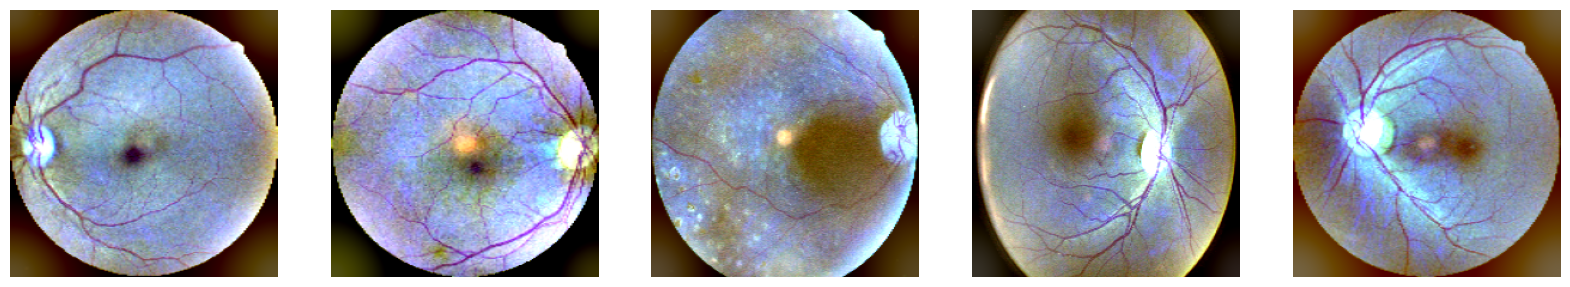

In [ ]:
# Visualizar las cinco primeras imágenes del generador de entrenamiento
print("Visualización de las cinco primeras imágenes del generador de entrenamiento:")
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    batch = next(train_data)
    image = batch[0][0]  # la primera imagen del lote
    image = np.clip(image, 0, 1)  # Limitar los valores de píxeles al rango [0, 1]
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

Visualización de las cinco primeras imágenes del generador de validación:


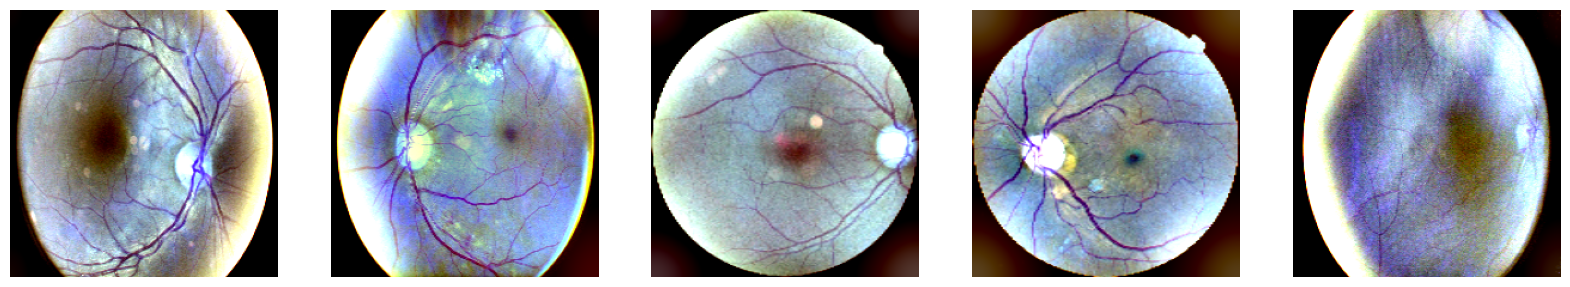

In [ ]:
# Visualizar las cinco primeras imágenes del generador de validación
print("Visualización de las cinco primeras imágenes del generador de validación:")
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    batch = next(val_data)
    image = batch[0][0]  # la primera imagen del lote
    image = np.clip(image, 0, 1)  # Limitar los valores de píxeles al rango [0, 1]
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

Visualización de las cinco primeras imágenes del generador de prueba:


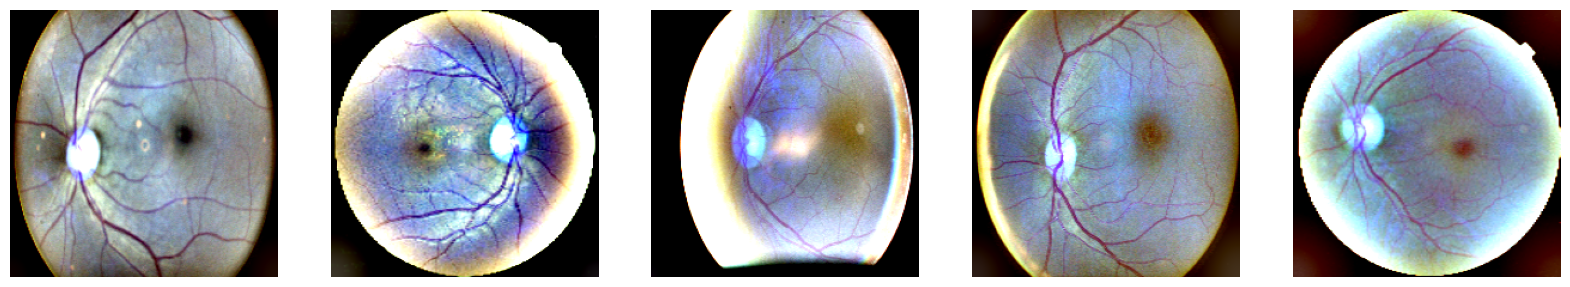

In [ ]:
# Visualizar las cinco primeras imágenes del generador de prueba
print("Visualización de las cinco primeras imágenes del generador de prueba:")
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    batch = next(test_data)
    image = batch[0][0]  # la primera imagen del lote
    image = np.clip(image, 0, 1)  # Limitar los valores de píxeles al rango [0, 1]
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

In [40]:
from keras.utils import to_categorical
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout


In [ ]:
# Considera aumentar el tamaño del kernel en las primeras capas de convolución para capturar características más grandes de las imágenes de retina.
model = Sequential()
model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())  # capa de normalización, Batch Normalization, después de las capas de convolución. Esto puede ayudar a estabilizar y acelerar el entrenamiento.


model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dropout(0.3))  # capas de regularización, como Dropout, para reducir el sobreajuste del modelo.
model.add(Dense(units=4096, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation="sigmoid"))  # capa de salida, cambia la función de activación a 'sigmoid' en lugar de 'softmax', ya que es una clasificación binaria.

# Ajusta la Tasa de Aprendizaje:
# - Experimenta con diferentes tasas de aprendizaje para el optimizador.
# - Una tasa de aprendizaje más baja puede ser útil para converger más lentamente pero con mayor precisión.

# Agrega Capas de Global Average Pooling:
# - Al final de la arquitectura, en lugar de utilizar una capa densa con muchos parámetros,
# - considera agregar capas de Global Average Pooling seguidas de una capa densa para reducir el número de parámetros y evitar el sobreajuste.



In [35]:
from keras.layers import Input # Input Layer
from keras.applications import DenseNet121 # Keras Application
from keras.layers import Dense # Dense Layer (Fully connected)
from keras.models import Model # Model Structure


input_shape=(224, 224, 3)

img_input = Input(shape=input_shape)
base_model = DenseNet121(include_top=False,
                         input_tensor=img_input,
                         input_shape=input_shape,
                         pooling="max",
                         weights='imagenet')
base_model.trainable = True

# Añadir la capa de salida para clasificación binaria
x = base_model.output
predictions = Dense(1,
                    activation="sigmoid",
                    name="predictions")(x)
model = Model(inputs=img_input,
              outputs=predictions)

29084464/29084464 [==============================] - 0s 0us/step


In [36]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.metrics import Precision, Recall, F1Score, AUC
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import keras
from keras.models import load_model
import datetime
from keras.saving import register_keras_serializable

Modificación de las métricas:

- modificamos la implementación de estas métricas para que devuelvan un solo valor escalar por paso de época. Para lograr esto utilizamos la función tf.reduce_mean() para calcular el promedio de los valores de las métricas a lo largo de todas las muestras del lote.

In [37]:
@keras.saving.register_keras_serializable()
class Precision(keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'))
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)

In [38]:
@keras.saving.register_keras_serializable()
class Recall(keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'))
        self.true_positives.assign_add(tp)
        self.false_negatives.assign_add(fn)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_negatives + keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_negatives.assign(0)


In [39]:
@keras.saving.register_keras_serializable()
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [40]:
@keras.saving.register_keras_serializable()
class AUC(keras.metrics.Metric):
    def __init__(self, name='auc', **kwargs):
        super(AUC, self).__init__(name=name, **kwargs)
        self.auc = tf.keras.metrics.AUC()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.auc.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.auc.result()

    def reset_state(self):
        self.auc.reset_states()

In [ ]:
model.compile(loss=binary_crossentropy, # calcula la entropía cruzada entre las distribuciones de probabilidad verdaderas y predichas para clasificación binaria.
              optimizer = Adam(learning_rate = 0.0001),  # # determina la magnitud de los pasos que el optimizador toma durante el proceso de optimización. Una tasa de aprendizaje más alta puede acelerar el proceso de convergencia, pero también puede hacer que el modelo oscile o diverja.
              metrics = ['accuracy', Precision(), Recall(), F1Score(), AUC()])


 - CALLBACKS

ModelCheckpoint: Esta devolución de llamada se utiliza para guardar el modelo durante el entrenamiento.
Permite guardar el modelo con la mejor precisión en el conjunto de validación (val_accuracy, en este caso) durante el entrenamiento.
Los parámetros específicos controlan el nombre del archivo (vgg16_1.h5), si se guarda solo el mejor modelo (save_best_only = True)
y otras configuraciones relacionadas con la frecuencia y el modo de guardado.

In [41]:
checkpoint = ModelCheckpoint(
    filepath="./densenet121-final-retrain-epoch8{epoch:02d}.h5",  # Formato de nombre de archivo con el número de la época
    monitor="val_recall",  # La métrica que se va a monitorear para decidir si guardar o no el modelo
    verbose=2,  # El nivel de detalle de los mensajes que se mostrarán durante el proceso de guardado del modelo
    save_best_only=False,  # Si se deben guardar solo los pesos del modelo que resulten en la mejor puntuación de la métrica monitoreada
    save_weights_only=False,  # Si se deben guardar solo los pesos del modelo (True) o el modelo completo (False)
    mode="max",  # Especifica si se debe maximizar ('max') o minimizar ('min') la métrica monitorizada
    save_freq="epoch"  # Guardar el modelo al final de cada época
)

EarlyStopping: Esta devolución de llamada detiene el entrenamiento si la precisión en el conjunto de validación no mejora después de cierto número
de épocas (patience = 3, en este caso). Esto ayuda a evitar el sobreajuste y a detener el entrenamiento una vez que el modelo deja de mejorar
significativamente en el conjunto de validación.
El parámetro mode = "auto" indica que la devolución de llamada determinará automáticamente si la métrica está mejorando o empeorando.

In [42]:
early = EarlyStopping(monitor = "val_recall",  # métrica que se va a monitorear para decidir si se detiene el entrenamiento del modelo.
                    patience = 6, # número de épocas sin mejora después de las cuales se detendrá el entrenamiento.
                    verbose = 2,
                    mode = "max",
                    restore_best_weights=True) # especifica si se restauran los pesos del modelo al final del entrenamiento con los mejores pesos obtenidos.

ReduceLROnPlateau:
Este callback se utiliza para reducir la tasa de aprendizaje cuando una métrica monitorizada deja de mejorar.
Es útil para ayudar al modelo a converger más rápido o a evitar oscilaciones en la última etapa del entrenamiento.
Se puede configurar para reducir la tasa de aprendizaje en un factor específico (factor) si no hay mejora durante un número determinado
de épocas consecutivas (patience).

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # métrica que se va a monitorear para decidir si se debe reducir la tasa de aprendizaje."val_loss" para la pérdida en el conjunto de validación
                              factor=0.01, # Factor por el cual se reducirá la tasa de aprendizaje. Después de que se activa la reducción de la tasa de aprendizaje, la nueva tasa será learning_rate = learning_rate * factor.
                              patience=4,  # Número de épocas sin mejora después del cual se reducirá la tasa de aprendizaje
                              verbose = 1,
                              mode = 'min',
                              min_lr=0.00001)

TensorBoard:
TensorBoard es una herramienta de visualización proporcionada por TensorFlow que permite monitorear y visualizar métricas de entrenamiento en tiempo real,
así como explorar el gráfico computacional del modelo, entre otras funcionalidades.
El callback TensorBoard se utiliza para guardar los registros de entrenamiento para su posterior visualización en TensorBoard.

In [44]:
from datetime import datetime

# Configuración de TensorBoard
log_dir = os.path.join("./drive/MyDrive/logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))


tensorboard = TensorBoard(log_dir=log_dir,  #  Directorio donde se guardarán los archivos de registro de TensorBoard. Los archivos de registro contienen información sobre el entrenamiento del modelo, como las métricas de rendimiento y la estructura del modelo.
                          histogram_freq=1,  # Frecuencia (en número de épocas) con la que se calcularán los histogramas de los pesos del modelo y las activaciones de las capas. Un histograma es una representación gráfica de la distribución de los valores en un conjunto de datos.
                          write_graph=True,  # Booleano que indica si se debe escribir la estructura del gráfico del modelo en los archivos de registro. Esto incluye información sobre las capas y las conexiones entre ellas.
                          write_images=True)  # Booleano que indica si se deben escribir imágenes de las capas del modelo en los archivos de registro. Estas imágenes pueden ser útiles para visualizar la arquitectura del modelo y cómo se propagan los datos a través de él durante el entrenamiento.

# Especifica el nombre del archivo CSV donde se guardarán los registros
csv_logger = CSVLogger('./drive/MyDrive/densenet121-final-retrain-h5-training.csv')

In [45]:
class MetricDifferenceMonitor(Callback):
    def __init__(self, monitor_metric='recall', threshold=0.4, verbose=0):
        super(MetricDifferenceMonitor, self).__init__()
        self.monitor_metric = monitor_metric
        self.threshold = threshold
        self.verbose = verbose
        self.train_metric_history = []
        self.val_metric_history = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        train_metric = logs.get(self.monitor_metric)
        val_metric = logs.get(f'val_{self.monitor_metric}')

        if train_metric is None or val_metric is None:
            return

        metric_difference = train_metric - val_metric
        self.train_metric_history.append(train_metric)
        self.val_metric_history.append(val_metric)

        if self.verbose > 0:
            print(f'Epoch {epoch + 1} - Difference between train and validation {self.monitor_metric}: {metric_difference}')

        if abs(metric_difference) > self.threshold:
            print(f'ALERT: Difference between train and validation {self.monitor_metric} exceeded {self.threshold * 100}% at epoch {epoch + 1}')

# Uso del Callback personalizado
metric_difference_monitor = MetricDifferenceMonitor(monitor_metric='recall', threshold=0.4, verbose=1)




In [ ]:
# Calcular los pesos de clase
total_samples = len(train_df)
class_weight = {
    0: total_samples / (2 * train_df['level'].value_counts()[0]),
    1: total_samples / (2 * train_df['level'].value_counts()[1])
}

# train_df['level'].value_counts() devuelve el recuento de muestras para cada clase en el conjunto de entrenamiento.
#Luego, los pesos de clase se calculan como el número total de muestras dividido por el doble del número de muestras para cada clase.
# Esto asegura que las clases minoritarias tengan un peso mayor durante el entrenamiento.

print("Class weights: ", class_weight)


model.fit(train_data,
          steps_per_epoch = 400,  # Número de pasos (lotes) para completar una época. Si no se especifica, se calculará automáticamente (800) en función del tamaño del conjunto de datos y el tamaño del lote.
          validation_data = val_data, #  Datos de validación. Si se proporciona, se utilizarán en lugar de validation_split - no hay para fit de keras
        # validation_steps = 10,
          epochs = 10,
          verbose=1,
          callbacks = [checkpoint, early, reduce_lr, tensorboard, csv_logger, metric_difference_monitor],
          class_weight = class_weight)

Class weights:  {0: 0.6787291747384735, 1: 1.89876436158682}
Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.6096 - precision: 0.3572 - recall: 0.5962 - f1_score: 0.4468 - auc: 0.6464 
Epoch 1: saving model to ./densenet121_preprocessed-retinal.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 - Difference between train and validation recall: -0.2409917712211609
400/400 [==============================] - 11256s 28s/step - loss: 0.9425 - accuracy: 0.6096 - precision: 0.3572 - recall: 0.5962 - f1_score: 0.4468 - auc: 0.6464 - val_loss: 1.2960 - val_accuracy: 0.4919 - val_precision: 0.3216 - val_recall: 0.8372 - val_f1_score: 0.4646 - val_auc: 0.6869 - lr: 1.0000e-04
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.6702 - precision: 0.4210 - recall: 0.6664 - f1_score: 0.5160 - auc: 0.7316 
Epoch 2: saving model to ./densenet121_preprocessed-retinal.h5
Epoch 2 - Difference between train and validation recall: 0.017210185527801514
400/400 [==============================] - 4572s 11s/step - loss: 0.7281 - accuracy: 0.6702 - precision: 0.4210 - recall: 0.6664 - f1_score: 0.5160 - auc: 0.7316 - val_loss: 0.7811 - val_accuracy: 0.6221 - val_precision: 0.3746 - val_recall: 0.6491 - val_f1_score: 0.4750 - val_auc: 0.6898 - lr: 1.0000e-0

-REENTRENAMIENTO

In [47]:
# Calcular los pesos de clase
total_samples = len(train_df)
class_weight = {
    0: total_samples / (2 * train_df['level'].value_counts()[0]),
    1: total_samples / (2 * train_df['level'].value_counts()[1])
}

In [ ]:
from keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/densenet121_preprocessed-retinal.h5')

# Continuar entrenando el modelo
model.fit(train_data,
          # steps_per_epoch = 800,  # Número de pasos (lotes) para completar una época. Si no se especifica, se calculará automáticamente (800) en función del tamaño del conjunto de datos y el tamaño del lote.
          validation_data = val_data, #  Datos de validación. Si se proporciona, se utilizarán en lugar de validation_split - no hay para fit de keras
        # vali dation_steps = 10,
          epochs = 10,
          verbose=1,
          callbacks = [checkpoint, early, reduce_lr, tensorboard, csv_logger, metric_difference_monitor],
          class_weight = class_weight)

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
876/876 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.7314 - precision: 0.4930 - recall: 0.7149 - f1_score: 0.5836 - auc: 0.8084 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: saving model to ./densenet121-preprocessed-retrain-epoch801.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  


Epoch 1 - Difference between train and validation recall: 0.2730756103992462
876/876 [==============================] - 13115s 15s/step - loss: 0.5784 - accuracy: 0.7314 - precision: 0.4930 - recall: 0.7149 - f1_score: 0.5836 - auc: 0.8084 - val_loss: 0.5193 - val_accuracy: 0.7872 - val_precision: 0.6389 - val_recall: 0.4419 - val_f1_score: 0.5224 - val_auc: 0.7575 - lr: 1.0000e-04
Epoch 2/10
876/876 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8236 - precision: 0.6269 - recall: 0.8157 - f1_score: 0.7089 - auc: 0.9033
Epoch 2: saving model to ./densenet121-preprocessed-retrain-epoch802.h5
Epoch 2 - Difference between train and validation recall: 0.4163448214530945
ALERT: Difference between train and validation recall exceeded 40.0% at epoch 2
876/876 [==============================] - 1432s 2s/step - loss: 0.3945 - accuracy: 0.8236 - precision: 0.6269 - recall: 0.8157 - f1_score: 0.7089 - auc: 0.9033 - val_loss: 0.5906 - val_accuracy: 0.8021 - val_precision: 

In [ ]:
from keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/densenet121_preprocessed-retinal.h5')

# Continuar entrenando el modelo
model.fit(train_data,
          # steps_per_epoch = 800,  # Número de pasos (lotes) para completar una época. Si no se especifica, se calculará automáticamente (800) en función del tamaño del conjunto de datos y el tamaño del lote.
          validation_data = val_data, #  Datos de validación. Si se proporciona, se utilizarán en lugar de validation_split - no hay para fit de keras
        # vali dation_steps = 10,
          epochs = 6,
          verbose=1,
          callbacks = [checkpoint, early, reduce_lr, tensorboard, csv_logger, metric_difference_monitor],
          class_weight = class_weight)


Epoch 1/6
876/876 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7335 - precision: 0.4959 - recall: 0.7282 - f1_score: 0.5900 - auc: 0.8068 
Epoch 1: saving model to ./densenet121-final-retrain-epoch801.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 - Difference between train and validation recall: 0.15485316514968872
876/876 [==============================] - 12462s 14s/step - loss: 0.5802 - accuracy: 0.7335 - precision: 0.4959 - recall: 0.7282 - f1_score: 0.5900 - auc: 0.8068 - val_loss: 0.5446 - val_accuracy: 0.7534 - val_precision: 0.5294 - val_recall: 0.5733 - val_f1_score: 0.5505 - val_auc: 0.7583 - lr: 1.0000e-04
Epoch 2/6
876/876 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.8228 - precision: 0.6256 - recall: 0.8142 - f1_score: 0.7075 - auc: 0.9042
Epoch 2: saving model to ./densenet121-final-retrain-epoch802.h5
Epoch 2 - Difference between train and validation recall: 0.28338146209716797
876/876 [==============================] - 3910s 4s/step - loss: 0.3925 - accuracy: 0.8228 - precision: 0.6256 - recall: 0.8142 - f1_score: 0.7075 - auc: 0.9042 - val_loss: 0.5663 - val_accuracy: 0.7683 - val_precision: 0.5639 - val_recall: 0.5308 - val_f1_score: 0.5469 - val_auc: 0.7667 - lr: 1.0000e-04


In [50]:
# Guardar el modelo
model.save('./drive/MyDrive/densenet121_total-final-preprocessed-retrain.h5')
model.save_weights('./drive/MyDrive/DenseNet121-total-final-retrain-pesos_entrenados.weights.h5')

In [51]:
print(tf.__version__)

2.13.0


- Accuracy (Precisión): Es la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas. Se calcula como el número de predicciones correctas dividido por el número total de predicciones.

- Precision (Precisión): Es la proporción de verdaderos positivos (instancias correctamente clasificadas como positivas) respecto a todas las instancias clasificadas como positivas (tanto verdaderos positivos como falsos positivos). Se calcula como verdaderos positivos dividido por la suma de verdaderos positivos y falsos positivos.

- Recall (Recuperación o Sensibilidad): Es la proporción de verdaderos positivos respecto a todas las instancias que realmente son positivas. Se calcula como verdaderos positivos dividido por la suma de verdaderos positivos y falsos negativos.

- F1 Score (Puntuación F1): Es la media armónica de precisión y recuperación (recall). Es útil cuando hay un desequilibrio entre las clases en el conjunto de datos. Se calcula como 2 * (precision * recall) / (precision + recall).

- AUC (Área bajo la curva ROC): Es el área bajo la curva ROC (Receiver Operating Characteristic). La curva ROC es una representación gráfica que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Un AUC más alto indica un mejor rendimiento del modelo en la clasificación binaria.

In [ ]:
import tensorboard

# Cargar la extensión tensorboard
%load_ext tensorboard


In [ ]:
tensorboard --logdir=./logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-05-21 20:21:01.935749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-21 20:21:03.430844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [ ]:
# Hacer predicciones sobre el conjunto de prueba
predictions = model.predict(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
188/188 [==============================] - 2185s 12s/step


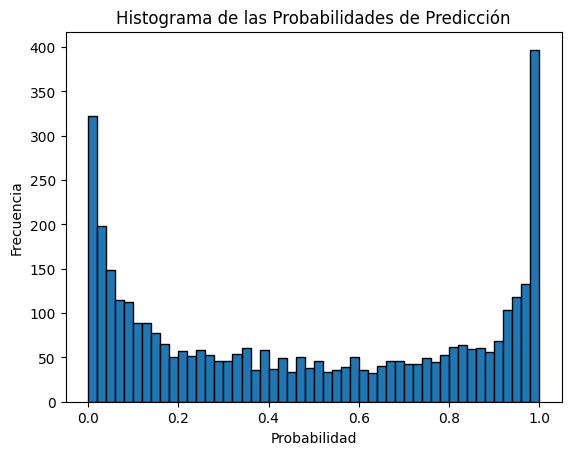

In [ ]:
# Histograma de las probabilidades de predicción
plt.hist(predictions, bins=50, edgecolor='k')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Histograma de las Probabilidades de Predicción')
plt.show()

In [ ]:
pred = (predictions > 0.7).astype("int32")
test = test_df['level'].astype('int32').to_numpy()

In [ ]:
test = test.flatten()
pred = pred.flatten()

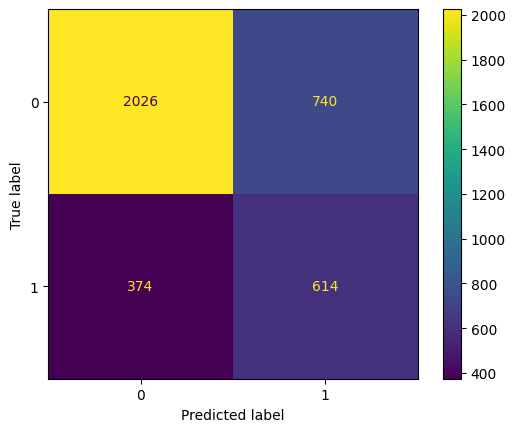

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
cm = confusion_matrix(test, pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


El modelo predijo correctamente que 2026 personas están sanas (0).
False Positives (FP): 740

El modelo predijo incorrectamente que 740 personas están enfermas (1), cuando en realidad están sanas (0).
False Negatives (FN): 374

El modelo predijo incorrectamente que 374 personas están sanas (0), cuando en realidad están enfermas (1).
True Positives (TP): 614

El modelo predijo correctamente que 614 personas están enfermas (1).

In [ ]:
df_pred = pd.DataFrame(predictions)
df_pred.to_csv('/content/drive/MyDrive/final-predictions-retrain.csv', index=False)

In [52]:
from keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/densenet121-final-retrain-epoch802.h5')

# Hacer predicciones sobre el conjunto de prueba
predictions_retrain = model.predict(test_data)

188/188 [==============================] - 1583s 8s/step


In [66]:
predictions_retrain = pd.DataFrame(predictions_retrain)
predictions_retrain.to_csv('/content/drive/MyDrive/total-final-predictions-retrain.csv', index=False)

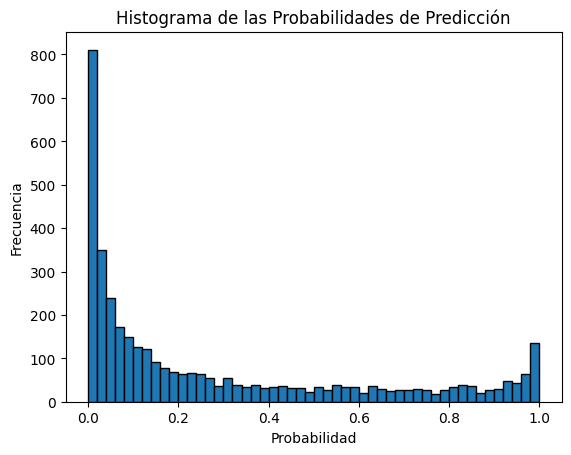

In [56]:
# Histograma de las probabilidades de predicción
plt.hist(predictions_retrain, bins=50, edgecolor='k')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Histograma de las Probabilidades de Predicción')
plt.show()

In [62]:
predict = (predictions_retrain > 0.2).astype("int32")
test = test_df['level'].astype('int32').to_numpy()

In [63]:
test = test.flatten()
predict = predict.flatten()

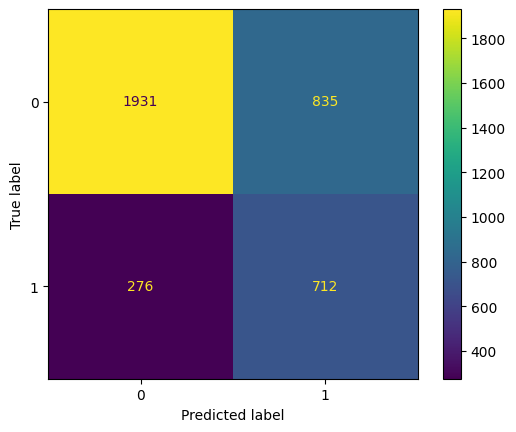

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
cm = confusion_matrix(test, predict)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [67]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
loss, accuracy, precision, recall, f1_score, AUC = model.evaluate(test_data)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("AUC-ROC:", AUC)

188/188 [==============================] - 377s 2s/step - loss: 0.5287 - accuracy: 0.7829 - precision: 0.5952 - recall: 0.5476 - f1_score: 0.5704 - auc: 0.7824
Loss: 0.5286982655525208
Accuracy: 0.7828982472419739
Precision: 0.5951595306396484
Recall: 0.5475708246231079
F1 Score: 0.5703741908073425
AUC-ROC: 0.7824370861053467


evaluate-modelo anterior

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
loss, accuracy, precision, recall, f1_score, AUC = model.evaluate(test_data)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("AUC-ROC:", AUC)

188/188 [==============================] - 223s 1s/step - loss: 0.8481 - accuracy: 0.6457 - precision: 0.4027 - recall: 0.7166 - f1_score: 0.5157 - auc: 0.7435
Loss: 0.8481371998786926
Accuracy: 0.6457112431526184
Precision: 0.40273037552833557
Recall: 0.71659916639328
F1 Score: 0.5156590342521667
AUC-ROC: 0.7434841990470886


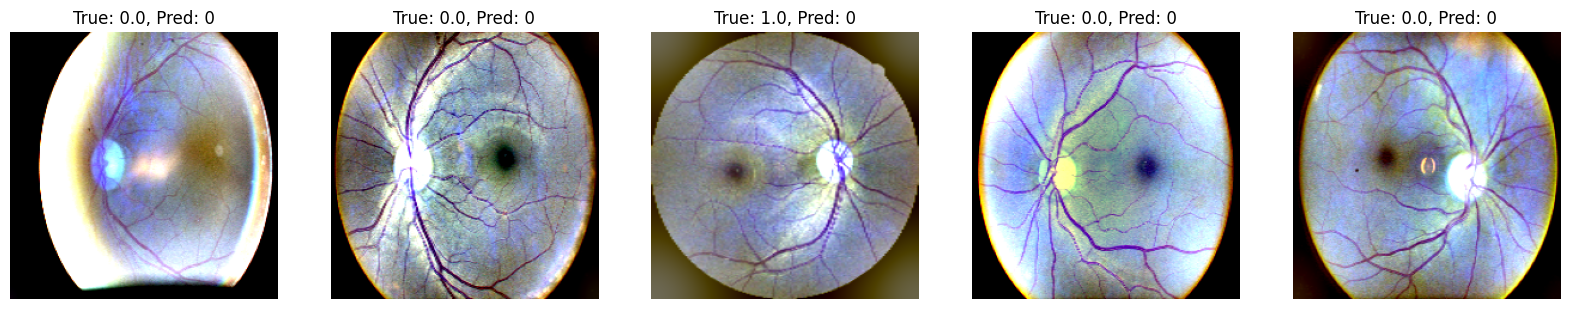

In [71]:
# Opcional: convertir las predicciones a etiquetas de clase
predicted_classes = np.argmax(predictions_retrain, axis=1)

# Seleccionar algunas imágenes para visualizar
num_images_to_display = 5
images, labels = next(iter(test_data))
predicted_labels = predicted_classes[:num_images_to_display]

# Mostrar las imágenes con sus etiquetas verdaderas y predichas
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(images[i])
    ax.set_title(f"True: {labels[i]}, Pred: {predicted_labels[i]}")
    ax.axis('off')
plt.show()

In [72]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

input_2 [(None, 224, 224, 3)]
zero_padding2d_2 (None, 230, 230, 3)
conv1/conv (None, 112, 112, 64)
conv1/bn (None, 112, 112, 64)
conv1/relu (None, 112, 112, 64)
zero_padding2d_3 (None, 114, 114, 64)
pool1 (None, 56, 56, 64)
conv2_block1_0_bn (None, 56, 56, 64)
conv2_block1_0_relu (None, 56, 56, 64)
conv2_block1_1_conv (None, 56, 56, 128)
conv2_block1_1_bn (None, 56, 56, 128)
conv2_block1_1_relu (None, 56, 56, 128)
conv2_block1_2_conv (None, 56, 56, 32)
conv2_block1_concat (None, 56, 56, 96)
conv2_block2_0_bn (None, 56, 56, 96)
conv2_block2_0_relu (None, 56, 56, 96)
conv2_block2_1_conv (None, 56, 56, 128)
conv2_block2_1_bn (None, 56, 56, 128)
conv2_block2_1_relu (None, 56, 56, 128)
conv2_block2_2_conv (None, 56, 56, 32)
conv2_block2_concat (None, 56, 56, 128)
conv2_block3_0_bn (None, 56, 56, 128)
conv2_block3_0_relu (None, 56, 56, 128)
conv2_block3_1_conv (None, 56, 56, 128)
conv2_block3_1_bn (None, 56, 56, 128)
conv2_block3_1_relu (None, 56, 56, 128)
conv2_block3_2_conv (None, 56, 56, 

In [73]:
import csv

# Abrir (o crear) el archivo CSV en modo escritura
with open('final-model_layers_output_shapes.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Escribir la cabecera del CSV
    writer.writerow(['Layer Name', 'Output Shape'])

    # Iterar sobre las capas del modelo y escribir los datos en el archivo CSV
    for layer in model.layers:
        writer.writerow([layer.name, layer.output_shape])

In [74]:
# Cargar el archivo CSV con los registros de entrenamiento
df = pd.read_csv('./drive/MyDrive/densenet121-final-retrain-h5-training.csv')
print(df.head())

   epoch  accuracy       auc  f1_score      loss      lr  precision    recall  \
0      0  0.733531  0.806790  0.590023  0.580191  0.0001   0.495940  0.728160   
1      1  0.822754  0.904243  0.707544  0.392546  0.0001   0.625583  0.814221   
2      2  0.892568  0.961881  0.813884  0.250427  0.0001   0.748318  0.892044   
3      3  0.925049  0.978422  0.866225  0.188735  0.0001   0.817186  0.921526   
4      4  0.944857  0.987634  0.900186  0.142900  0.0001   0.860020  0.944288   

   val_accuracy   val_auc  val_f1_score  val_loss  val_precision  val_recall  
0      0.753395  0.758324      0.550485  0.544558       0.529412    0.573306  
1      0.768309  0.766734      0.546875  0.566280       0.563910    0.530839  
2      0.763249  0.739495      0.516059  0.750542       0.558962    0.479272  
3      0.503063  0.723309      0.475548  1.393307       0.329311    0.855410  
4      0.774168  0.766874      0.555556  0.757793       0.576714    0.535895  


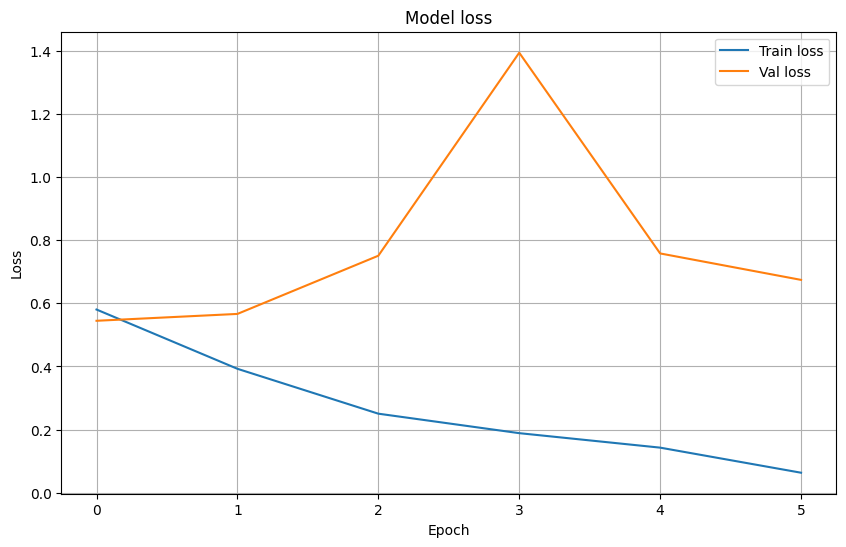

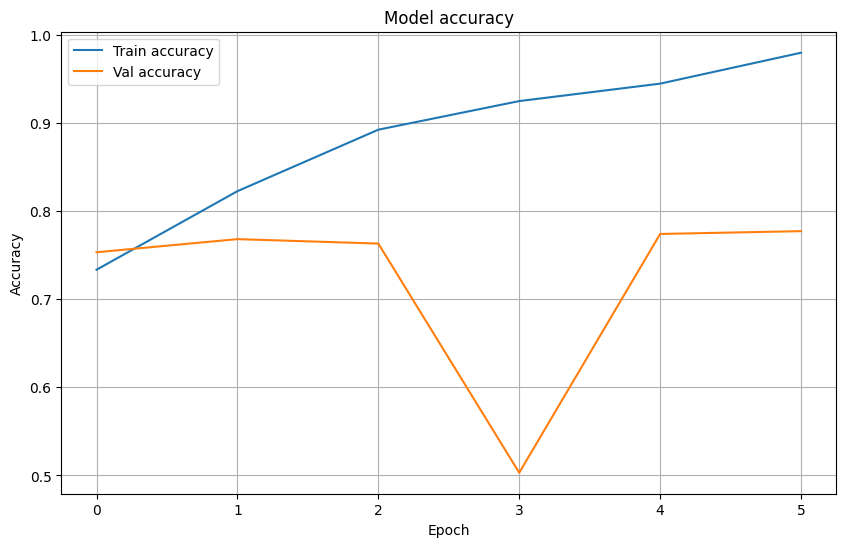

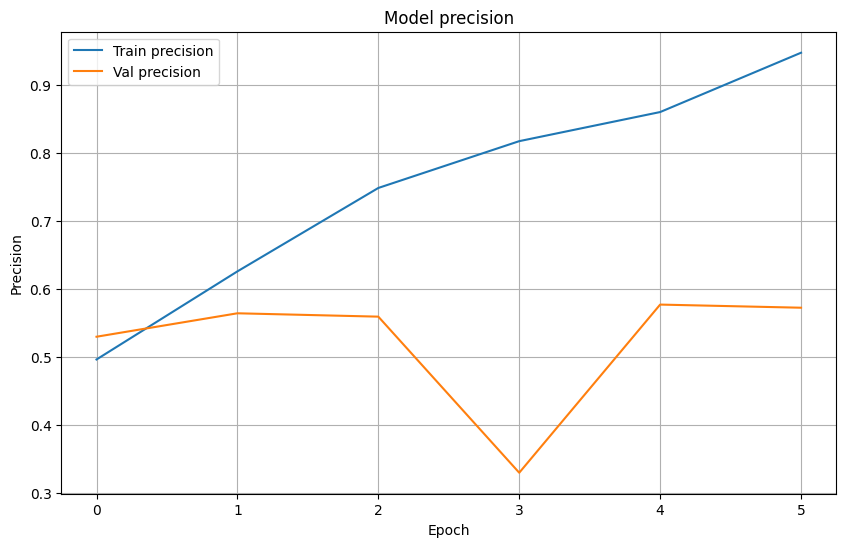

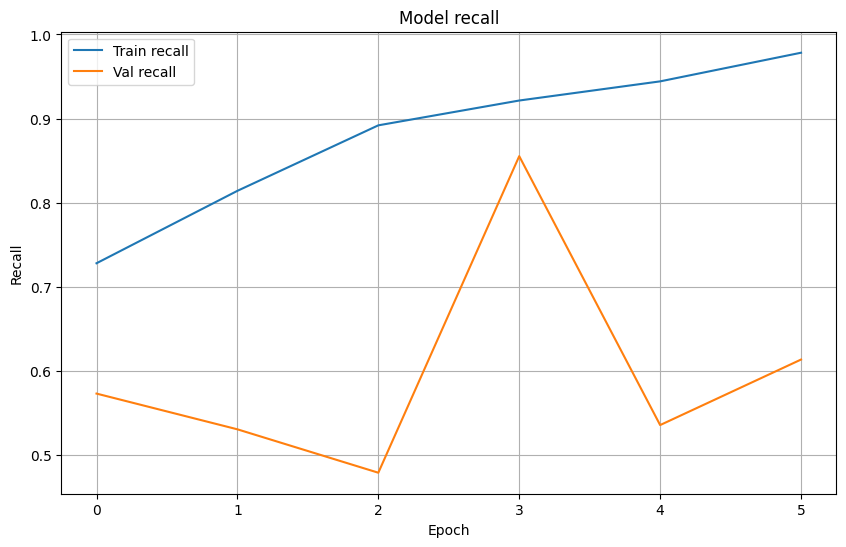

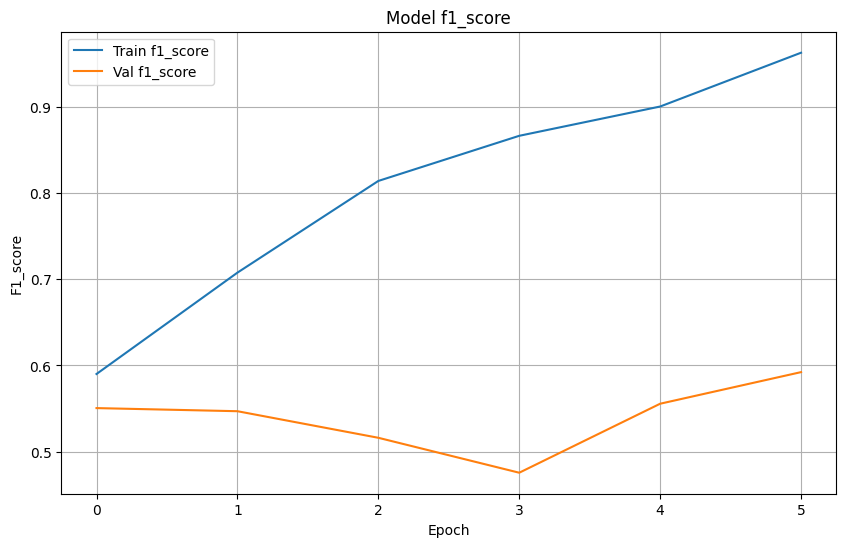

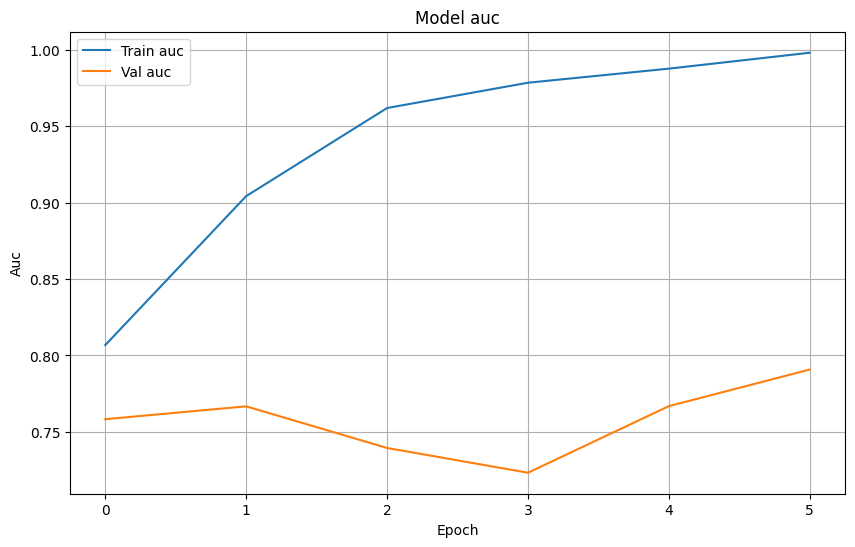

In [75]:
# Listado de las métricas disponibles en el archivo CSV
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'auc']

# Graficar las métricas
for metric in metrics:
    plt.figure(figsize=(10, 6))

    # Graficar el entrenamiento
    plt.plot(df[metric], label=f'Train {metric}')

    # Graficar la validación
    plt.plot(df[f'val_{metric}'], label=f'Val {metric}')

    # Etiquetas y título
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [76]:
pip install scikit-learn joblib

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from keras.layers import Input, Dense
from keras.models import Model
from keras.applications import DenseNet121
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score

In [ ]:
# Define custom transformer for image preprocessing
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, sigmaX=10):
        self.sigmaX = sigmaX

    def crop_image_from_gray(self, img, tol=7):
        if img.ndim == 2:
            mask = img > tol
            return img[np.ix_(mask.any(1), mask.any(0))]
        elif img.ndim == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img > tol
            check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
            if check_shape == 0:
                return img
            else:
                img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
                img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
                img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
                img = np.stack([img1, img2, img3], axis=-1)
            return img

    def load_ben_color(self, image, sigmaX=10):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.crop_image_from_gray(image)
        image = cv2.resize(image, (224, 224))
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
        return image

    def preprocess_rgb_images(self, image, sigmaX=10):
        try:
            image = self.load_ben_color(image, sigmaX=30)
            return image
        except Exception as e:
            print(f"Error preprocessing image: {e}")
            return None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.preprocess_rgb_images(img) for img in X])


In [ ]:
# Build the Keras model
def create_model(input_shape=(224, 224, 3)):
    img_input = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False, input_tensor=img_input, input_shape=input_shape, pooling="max", weights='imagenet')
    base_model.trainable = True

    x = base_model.output
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    model = Model(inputs=img_input, outputs=predictions)

    model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy', Precision(), Recall(), F1Score(), AUC()])
    return model

# Create the pipeline
preprocessor = ImagePreprocessor()
model = create_model()

In [ ]:
# Save the model using the defined pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [ ]:
# To save the pipeline
joblib.dump(pipeline, 'model_pipeline.pkl')


['model_pipeline.pkl']

In [ ]:
# To load the pipeline
# pipeline = joblib.load('model_pipeline.pkl')
#modelo = load_model('../models/densenet121_model.h5')
#modelo.load_weights('../models/pesos_entrenados.weights.h5')

Mejorar y explorar el modelo:

- Ajuste de hiperparámetros:
Experimenta con diferentes configuraciones de hiperparámetros para ver cómo afectan al rendimiento del modelo. Puedes ajustar la tasa de aprendizaje, el número de capas y neuronas, el tamaño del lote, la función de activación, entre otros.

- Regularización:
Prueba diferentes técnicas de regularización, como la disminución de la tasa de aprendizaje, la regularización L1 o L2, la reducción de la dimensionalidad, o la técnica de abandono (dropout), para mejorar la generalización del modelo y evitar el sobreajuste.

- Transferencia de aprendizaje:
Utiliza modelos preentrenados y realiza transferencia de aprendizaje para adaptarlos a tu problema específico. Esto puede ayudarte a obtener buenos resultados incluso con conjuntos de datos pequeños.

- Visualización de resultados:
Visualiza las métricas de rendimiento, como la precisión y la pérdida, a lo largo del tiempo utilizando gráficos. Esto te ayudará a comprender cómo está progresando el entrenamiento del modelo y si está convergiendo adecuadamente.

- Análisis de errores:
Analiza las predicciones incorrectas del modelo para identificar patrones o tendencias comunes. Esto puede proporcionarte información valiosa sobre las debilidades del modelo y posibles áreas de mejora.

- Exploración de datos:
Explora tus datos para comprender mejor su distribución, identificar posibles problemas de calidad de datos y encontrar formas de mejorar el preprocesamiento.

- Optimización del rendimiento:
Si estás trabajando en un entorno con recursos limitados, como en un dispositivo móvil o en la nube, considera técnicas de optimización del rendimiento, como la cuantización de modelos o la optimización del tamaño del modelo, para reducir el consumo de recursos sin comprometer el rendimiento.

- Experimentación continua:
La experimentación continua es clave para el desarrollo de modelos de aprendizaje automático exitosos. No tengas miedo de probar nuevas ideas y técnicas, y sigue iterando y refinando tu modelo en función de los resultados obtenidos.